In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
tensor_train_x = torch.linspace(0, 1, 100)
tensor_train_y = np.sin(tensor_train_x * (2 * np.pi)) + torch.randn(tensor_train_x.size()) * np.sqrt(0.04)


train_x = tensor_train_x.numpy()
train_y = tensor_train_y.numpy()



In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size=1)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1/2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(tensor_train_x, tensor_train_y, likelihood)

In [6]:
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(tensor_train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, tensor_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.921   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.884   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.848   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.814   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 0.780   lengthscale: 0.909   noise: 0.513
Iter 6/50 - Loss: 0.746   lengthscale: 0.966   noise: 0.474
Iter 7/50 - Loss: 0.712   lengthscale: 1.023   noise: 0.437
Iter 8/50 - Loss: 0.680   lengthscale: 1.078   noise: 0.403
Iter 9/50 - Loss: 0.647   lengthscale: 1.130   noise: 0.371
Iter 10/50 - Loss: 0.615   lengthscale: 1.175   noise: 0.341
Iter 11/50 - Loss: 0.583   lengthscale: 1.213   noise: 0.313
Iter 12/50 - Loss: 0.552   lengthscale: 1.242   noise: 0.287
Iter 13/50 - Loss: 0.521   lengthscale: 1.261   noise: 0.263
Iter 14/50 - Loss: 0.490   lengthscale: 1.271   noise: 0.240
Iter 15/50 - Loss: 0.460   lengthscale: 1.274   noise: 0.220
Iter 16/50 - Loss: 0.430   lengthscale: 1.272   noise: 0.201
Iter 17/50 - Loss: 0.402   length

In [7]:
tensor_test_x = torch.linspace(0,1,51)
test_x = tensor_test_x.numpy()

model.eval()
likelihood.eval()


f_preds = model(tensor_test_x)
y_preds = likelihood(model(tensor_test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size((1000,)))

In [8]:
import cProfile
cProfile.run('f_preds.mean')

         4 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 multivariate_normal.py:194(mean)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [9]:
model(tensor_test_x).__dict__

{'_islazy': True,
 'loc': tensor([-0.0568,  0.2431,  0.2479,  0.4602,  0.5442,  0.6400,  0.7646,  0.7824,
          0.7888,  0.8522,  0.8905,  0.8684,  0.7908,  0.8091,  0.8892,  1.0327,
          0.9976,  0.7537,  0.5831,  0.6673,  0.5579,  0.4502,  0.3195,  0.2687,
          0.1073,  0.0158,  0.0360, -0.2374, -0.4607, -0.6344, -0.6184, -0.6587,
         -0.6895, -0.8948, -0.9999, -0.9631, -1.0015, -1.1445, -1.1935, -1.0085,
         -0.9149, -0.8831, -0.8176, -0.6887, -0.5287, -0.4254, -0.5453, -0.5145,
         -0.2454, -0.0291, -0.0014], grad_fn=<ViewBackward0>),
 '_covar': <linear_operator.operators.dense_linear_operator.DenseLinearOperator at 0x7f18ce0917f0>,
 '_MultivariateNormal__unbroadcasted_scale_tril': None,
 '_validate_args': False,
 '_batch_shape': torch.Size([]),
 '_event_shape': torch.Size([51])}

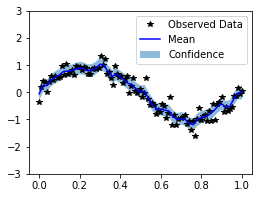

In [10]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
with torch.no_grad():
    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x, train_y, 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x, f_preds.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x, lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])


In [11]:
model.covar_module.base_kernel.lengthscale

tensor([[0.4329]], grad_fn=<SoftplusBackward0>)

In [12]:
model.mean_module._parameters

OrderedDict([('weights',
              Parameter containing:
              tensor([[-0.2445]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([0.1107], requires_grad=True))])

In [14]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.3911])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.weights', tensor([[-0.2445]])),
             ('mean_module.bias', tensor([0.1107])),
             ('covar_module.raw_outputscale', tensor(-0.6222)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.6129]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [15]:
np.atleast_2d([1,2,3])

array([[1, 2, 3]])

In [71]:
from scipy.spatial.distance import cdist

class numpy_LinearMean():
    def __init__(self, weight, bias):
        self.weight = weight
        self.bias   = bias
    def __call__(self, input):
        return self.weight * input + self.bias

class numpy_ScaleKernel():
    def __init__(self, base_kernel, scale):
        self.base_kernel = base_kernel
        self.scale = scale
    
    def __call__(self, x1, x2 = None):
        if(x2 is None):
            x2 = x1
        return self.base_kernel(x1, x2)*self.scale

class numpy_MaternKernel():
    def __init__(self, nu, lengthscale):
        self.nu = nu
        self.lengthscale = lengthscale 
    def __call__(self, x1, x2 = None):
        _x1 = x1 / self.lengthscale
        
        if(x2 is None):
            x2 = x1

        _x2 = x2 / self.lengthscale
        

        if(len(x1.shape) == 1): #handle 1d data
            _x1 = np.expand_dims(x1, axis=1) / self.lengthscale
            _x2 = np.expand_dims(x2, axis=1) / self.lengthscale
            
        distance = cdist(_x1, _x2, 'minkowski', p=2)
        
        exp_component = np.exp(-np.sqrt(self.nu * 2.) * distance)

        if self.nu == 0.5:
            constant_component = 1
        elif self.nu == 1.5:
            constant_component = (np.sqrt(3) * distance) + 1.
        elif self.nu == 2.5:
            constant_component = (np.sqrt(5) * distance)+ 1. + (5/3 * distance**2)
        
        return constant_component * exp_component


In [72]:
model.likelihood.noise_covar.noise.detach().numpy()[0]

0.03321757

In [73]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.3911])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.weights', tensor([[-0.2445]])),
             ('mean_module.bias', tensor([0.1107])),
             ('covar_module.raw_outputscale', tensor(-0.6222)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.6129]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [74]:
model.covar_module.base_kernel.lengthscale

tensor([[0.4329]], grad_fn=<SoftplusBackward0>)

In [75]:
gpytorch_mean = model.mean_module(tensor_train_x)
tmp_mean_module = numpy_LinearMean(model.mean_module.weights.item(), model.mean_module.bias.item())

np.allclose(gpytorch_mean.detach().numpy(), 
            tmp_mean_module(train_x) )

True

In [76]:
model.covar_module.base_kernel.lengthscale.detach().numpy()[0][0]

0.43293658

In [77]:
tmp_base_kernel = numpy_MaternKernel(nu=1/2, lengthscale = model.covar_module.base_kernel.lengthscale.detach().numpy()[0,0])

In [78]:
gpytorch_base_oup = model.covar_module.base_kernel(tensor_train_x, tensor_test_x).to_dense().detach().numpy()
my_base_oup = tmp_base_kernel(train_x, test_x)

In [79]:
print(gpytorch_base_oup)

[[1.         0.9548534  0.9117474  ... 0.10889024 0.10397437 0.0992804 ]
 [0.9769371  0.9773935  0.9332696  ... 0.11146067 0.10642876 0.10162399]
 [0.9544085  0.99940217 0.9553005  ... 0.11409178 0.10894106 0.1040229 ]
 ...
 [0.1040229  0.10894109 0.11409178 ... 0.95529926 0.99951184 0.9544085 ]
 [0.10162399 0.10642876 0.11146067 ... 0.9332696  0.9773935  0.9769396 ]
 [0.0992804  0.10397437 0.10889024 ... 0.9117468  0.95485467 1.        ]]


In [80]:
print(my_base_oup)

[[1.         0.95485466 0.91174742 ... 0.10889024 0.10397435 0.0992804 ]
 [0.97693869 0.97739466 0.93326985 ... 0.11146067 0.10642873 0.10162399]
 [0.9544092  0.99953348 0.95530033 ... 0.11409178 0.10894106 0.10402289]
 ...
 [0.1040229  0.10894108 0.11409179 ... 0.95530043 0.99953329 0.95440916]
 [0.10162399 0.10642875 0.11146068 ... 0.93326993 0.97739483 0.97693867]
 [0.0992804  0.10397436 0.10889025 ... 0.91174749 0.95485481 1.        ]]


In [81]:
np.allclose(gpytorch_base_oup, my_base_oup, atol=0, rtol=1e-3)

True

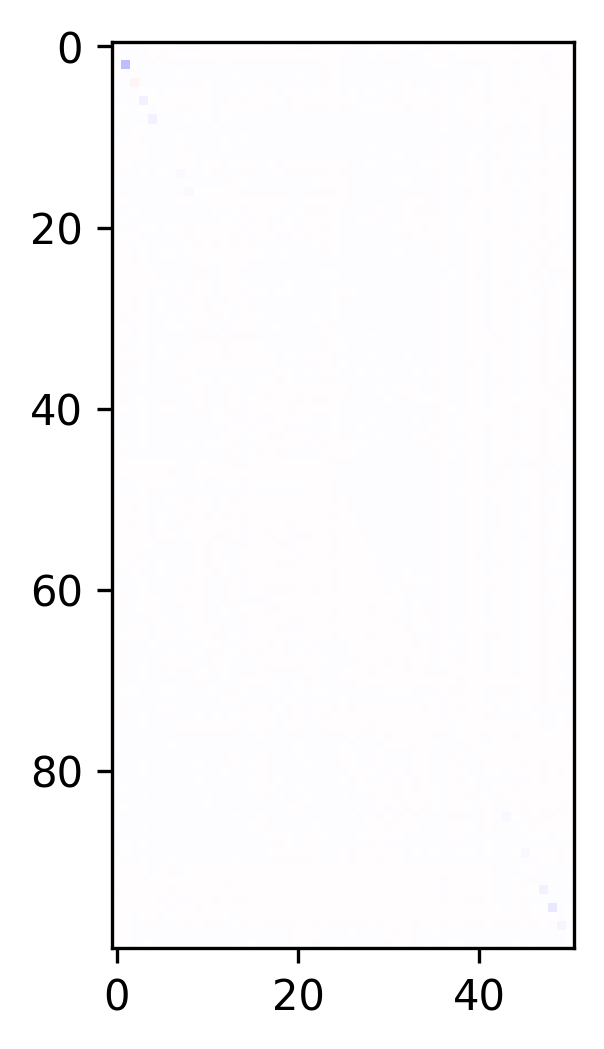

In [82]:
plt.figure(dpi=300)
plt.imshow((gpytorch_base_oup - my_base_oup)/gpytorch_base_oup, vmin=-0.001, vmax=0.001, cmap='seismic')

In [83]:
tmp_covar_module = numpy_ScaleKernel(tmp_base_kernel, 
                                     model.covar_module.outputscale.detach().numpy())


In [84]:
gpytorch_cov_oup = model.covar_module(tensor_train_x, tensor_test_x).to_dense().detach().numpy()
my_cov_oup = tmp_covar_module(train_x, test_x)

In [88]:
np.allclose(gpytorch_cov_oup, my_cov_oup, rtol=1e-3)

True

In [89]:
class numpy_MultivariateNormal():
    def __init__(self, mean, covariance_matrix):
        self.loc = mean
        self._covar = covariance_matrix
        
    def confidence_region(self):
        std2 = 2*np.sqrt(np.diag(self._covar))
        mean = self.mean
        return mean - std2, mean + std2
    
my_pred = numpy_MultivariateNormal(tmp_mean_module(test_x), tmp_covar_module(test_x))

In [90]:
import scipy

In [91]:
KXSX = tmp_covar_module(test_x, train_x)
KXSXS = tmp_covar_module(test_x, test_x)
KXXS = tmp_covar_module(train_x, test_x)
KXX = tmp_covar_module(train_x, train_x) + model.likelihood.noise_covar.noise.detach().numpy()[0] * np.eye(train_x.shape[0])
L = np.linalg.cholesky(KXX)

_y = train_y - tmp_mean_module(train_x)

alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, _y, lower=True))

my_predictive_mean = np.einsum('ij,j->i', KXSX, alpha)+ tmp_mean_module(test_x)


beta = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, KXXS, lower=True))


my_predictive_cov = KXSXS - np.einsum('ij,jk->ik', KXSX, beta)

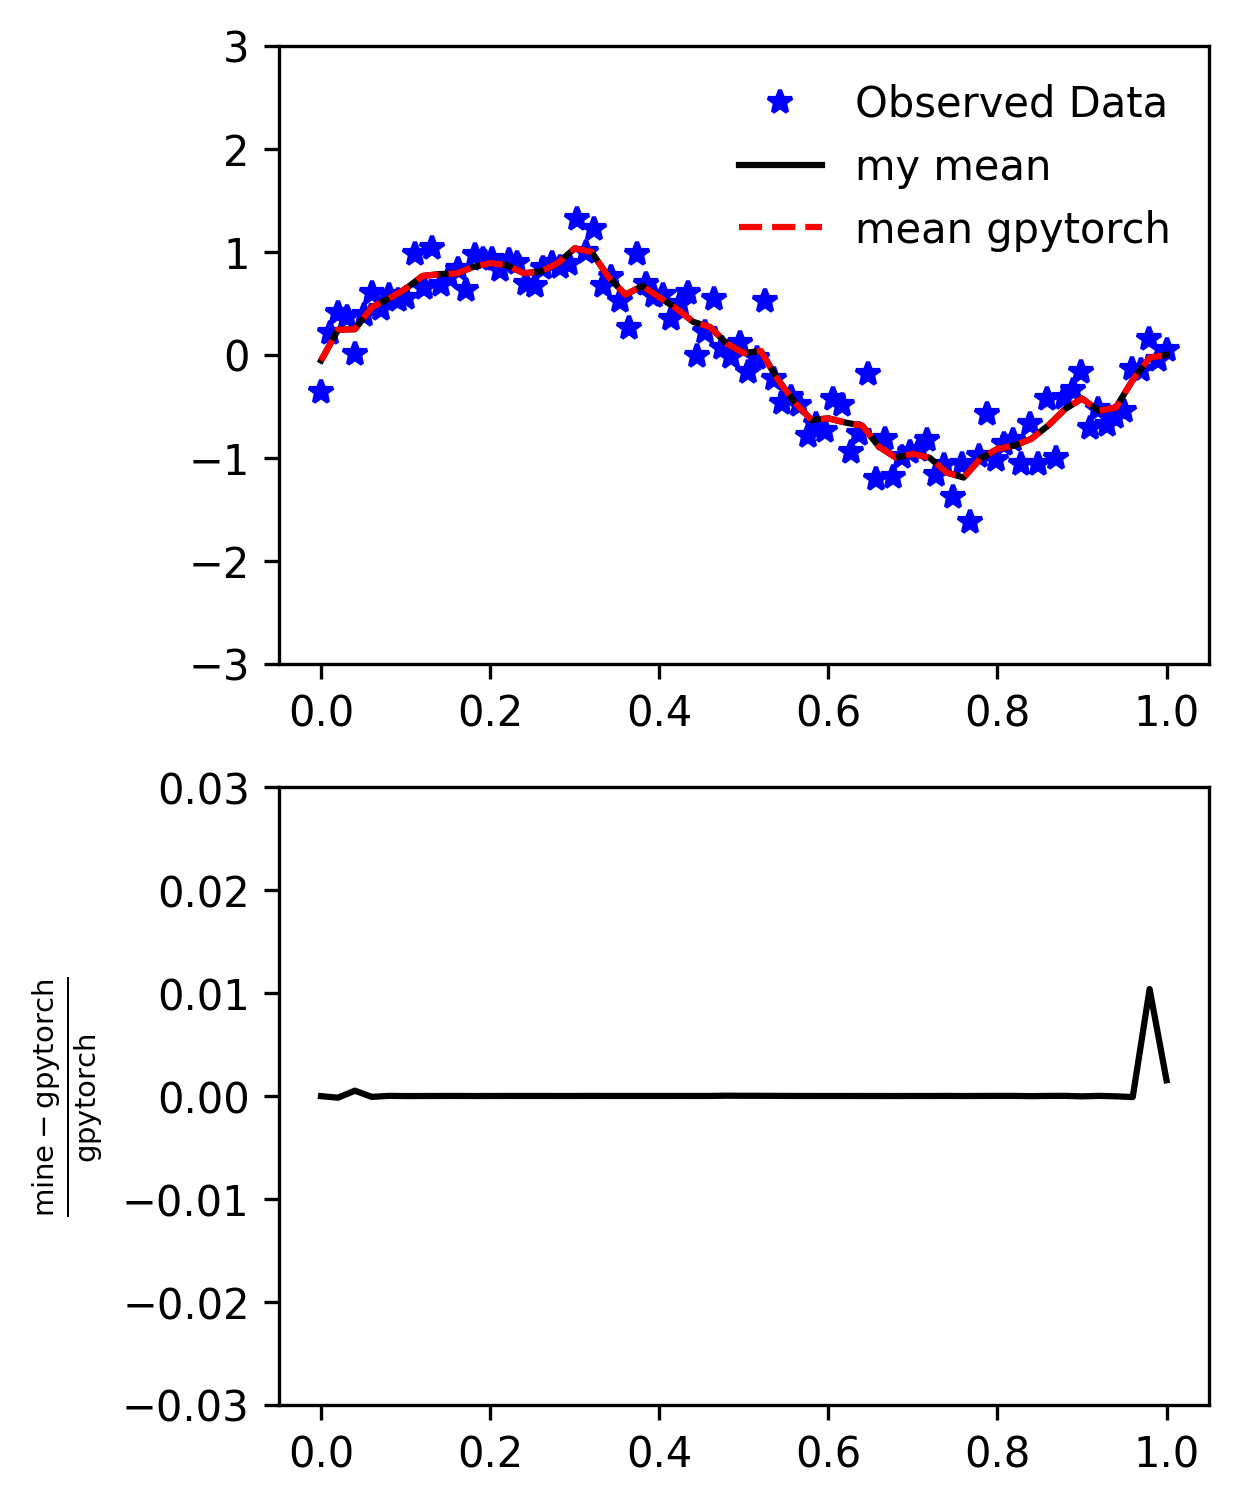

In [97]:
# Initialize plot
f, ax = plt.subplots(2, 1, figsize=(4, 6), dpi=300)

with torch.no_grad():

    # Plot training data as black stars
    ax[0].plot(train_x, train_y, 'b*')

    ax[0].plot(test_x, my_predictive_mean, 'k')
    ax[0].plot(test_x, f_preds.mean.numpy(), 'r--')

    ax[0].set_ylim([-3, 3])
    ax[0].legend(['Observed Data', 'my mean', 'mean gpytorch'], frameon=False)

    
    ax[1].plot(test_x, (f_preds.mean.numpy()-my_predictive_mean)/f_preds.mean.numpy(), 'k')
    ax[1].set_ylabel(r'$\frac{{\rm mine} - {\rm gpytorch}}{\rm gpytorch}$')
    ax[1].set_ylim(-3e-2, 3e-2)